In [2]:
import numpy as np
from scipy import fft
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import time
from tabulate import tabulate

base_path = '/Users/max/Documents/HHU Mathe/Bachelorarbeit/Tex/images'

In [3]:
# Setup
N = 1000 # Number of discretization points
L = 1  # Length of domain 
dx = L/(N+1)
x = np.arange(-L/2,L/2,dx) # Define x domain
x = x[:N]
t_range = 0.05
dt = 0.0001
t = np.arange(0,t_range,dt)
alpha = .6   # Thermal diffusivity constant

# Plotting settings
plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams.update({'font.size': 14})

In [4]:
%run -i Functions.py

# Initial condition
u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)

# FOM
u = Simulate_Heat_FOM(u0, x, t, alpha)

Using Sirovich Method...
Rank of truncation: r = 1
Using Sirovich Method...
Rank of truncation: r = 2


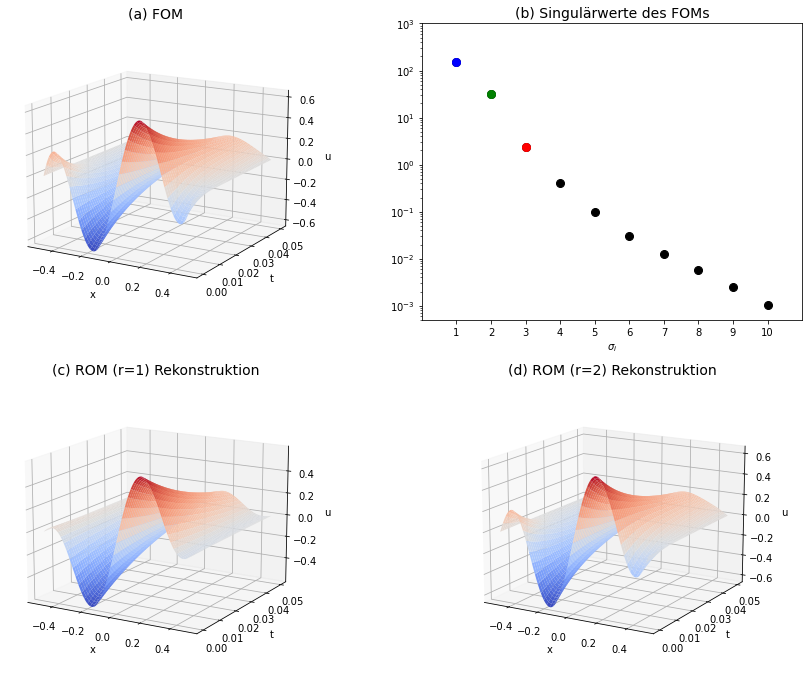

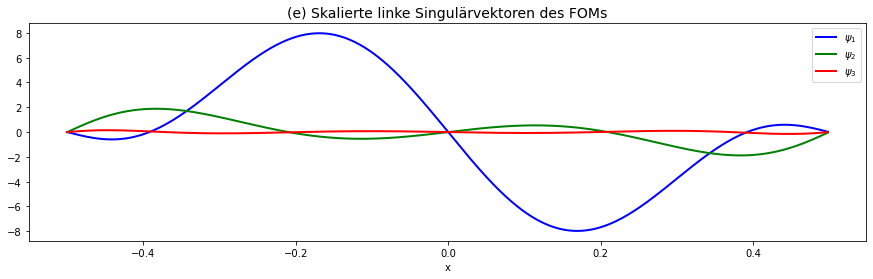

In [5]:
%run -i Functions.py

# ROMs
u_rom1 = Simulate_Heat_ROM_with_tolerance(u, u0, x, t, alpha, .8)
u_rom2 = Simulate_Heat_ROM_with_tolerance(u, u0, x, t, alpha, .99)
#u_rom3 = Simulate_Heat_ROM_with_tolerance(u, u0, x, t, alpha, .9999)

Psi,Sigma,PhiT = np.linalg.svd(u)

x_mesh,t_mesh = np.meshgrid(x,t)

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(15,12))
#fig.subplots_adjust(wspace=.1,hspace=.1)

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.view_init(elev=15, azim=300)
ax1.plot_surface(x_mesh.T, t_mesh.T, u.real, cmap=plt.cm.coolwarm)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('u')
ax1.set_title('(a) FOM', fontdict={'fontsize':'14'})

ax2 = fig.add_subplot(2,2,2)
ax2.plot(np.arange(1,11),Sigma[:10],'ko',ms=8)
ax2.plot(1,Sigma[0],'bo',ms=8)
ax2.plot(2,Sigma[1],'go',ms=8)
ax2.plot(3,Sigma[2],'ro',ms=8)
ax2.set_xlim(0,11)
ax2.set_ylim(0.5e-3,1e3)
ax2.set_xticks(np.arange(1,11))
ax2.set_yscale('log')
ax2.set_xlabel(r'$\sigma_i$')
ax2.set_title('(b) Singulärwerte des FOMs', fontdict={'fontsize':'14'})

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.view_init(elev=15, azim=300)
ax3.plot_surface(x_mesh.T, t_mesh.T, u_rom1.real, cmap=plt.cm.coolwarm)
ax3.set_xlabel('x')
ax3.set_ylabel('t')
ax3.set_zlabel('u')
ax3.set_title('(c) ROM (r=1) Rekonstruktion', fontdict={'fontsize':'14'})

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.view_init(elev=15, azim=300)
ax4.plot_surface(x_mesh.T, t_mesh.T, u_rom2.real, cmap=plt.cm.coolwarm)
ax4.set_xlabel('x')
ax4.set_ylabel('t')
ax4.set_zlabel('u')
ax4.set_title('(d) ROM (r=2) Rekonstruktion', fontdict={'fontsize':'14'})

fig2 = plt.figure(figsize=(15,4))
ax5 = fig2.add_subplot(1, 1, 1)
color_list = ['b','g','r']
for jj in range(3):
    ax5.plot(x,np.real(Psi[:,jj]*Sigma[jj]),color=color_list[jj],linewidth=2, \
             label=r'$\psi_{}$'.format(jj+1))
ax5.set_xlabel('x')
ax5.set_title('(e) Skalierte linke Singulärvektoren des FOMs', fontdict={'fontsize': '14'})

fig.savefig(f'{base_path}/FOM_Analysis1.png', bbox_inches='tight', dpi=600)
fig.savefig(f'{base_path}/FOM_Analysis1.svg', bbox_inches='tight', dpi=600)
fig2.savefig(f'{base_path}/FOM_Analysis2.png', bbox_inches='tight', dpi=600)
fig2.savefig(f'{base_path}/FOM_Analysis2.svg', bbox_inches='tight', dpi=600)

plt.legend()
plt.show()

In [8]:
%run -i Functions.py

##### Determine Errors for different k's #####

model_error = np.zeros(5)
projection_error = np.zeros(5)
total_error = np.zeros(5)
relative_error = np.zeros(5)

# Simulate FOM
N = 1000
dx = L/(N+1)
x = np.arange(-L/2,L/2,dx)
x = x[:N]
u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)
u = Simulate_Heat_FOM(u0, x, t, alpha)
Psi,Sigma,PhiT = np.linalg.svd(u)

for r in range(1,6):
    print(f'Fehler wurde berechnet für r = {r}')
    u_rom = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, r)
    Psi_inner = Psi[:,:r]@Psi[:,:r].T
    
    u_total = 0
    for tt in range(t.size):
        model_error[r-1] += np.linalg.norm(Psi_inner@u[:,tt] - u_rom[:,tt])**2
        projection_error[r-1] += np.linalg.norm(u[:,tt] - Psi_inner@u[:,tt])**2
        total_error[r-1] += np.linalg.norm(u[:,tt] - u_rom[:,tt])**2
        u_total += np.linalg.norm(u[:,tt])**2
    relative_error[r-1] = total_error[r-1]/u_total
        
# Plot of Timings
data = [1, model_error[0], projection_error[0], total_error[0], f'{round(100*relative_error[0],5)}%']

for r in range(2,5):
    data = np.vstack((data,[r, model_error[r-1], projection_error[r-1], total_error[r-1], f'{round(100*relative_error[r-1],5)}%']))
  
#define header names
col_names = ["r", "Modellierungsfehler", "Projektionsfehler", "Gesamtfehler", "Relativer Fehler"]
    
print(f'Gesamtsumme der Energie des Systems: {np.sum(np.power(Sigma, 2))}')    
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

Fehler wurde berechnet für r = 1
(1000, 1)
Fehler wurde berechnet für r = 2
(1000, 2)
Fehler wurde berechnet für r = 3
(1000, 3)
Fehler wurde berechnet für r = 4
(1000, 4)
Fehler wurde berechnet für r = 5
(1000, 5)
Gesamtsumme der Energie des Systems: 23923.351167114244
╒═════╤═══════════════════════╤═════════════════════╤════════════════╤════════════════════╕
│   r │   Modellierungsfehler │   Projektionsfehler │   Gesamtfehler │ Relativer Fehler   │
╞═════╪═══════════════════════╪═════════════════════╪════════════════╪════════════════════╡
│   1 │           31.437      │        1043.91      │   1075.34      │ 4.49495%           │
├─────┼───────────────────────┼─────────────────────┼────────────────┼────────────────────┤
│   2 │            0.0517272  │           5.94694   │      5.99867   │ 0.02507%           │
├─────┼───────────────────────┼─────────────────────┼────────────────┼────────────────────┤
│   3 │            0.0107297  │           0.172736  │      0.183466  │ 0.00077%      

In [39]:
%run -i Functions.py

##### Determine Times for different N's #####
N_arr = [500, 2000, 5000]

# [simulation_time, reconstruction_time]
# Offline-Phase Teil (1) und (2)
FOM_times = np.zeros((3,2))
# [linear_operator_time, simulation_time, reconstruction_time]
# Offlie-Phase Teil (3) und Online-Phase Teil (1) und (2)
ROM_times = np.zeros((3,3))


counter = 0

for j in range(len(N_arr)):
    # Simulate FOM
    N = N_arr[j]
    dx = L/(N+1)

    x = np.arange(-L/2,L/2,dx)
    x = x[:N]
    u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)
    u, FOM_time_arr = Simulate_Heat_FOM_with_timing(u0, x, t, alpha)
    FOM_times[j,:] = FOM_time_arr
    u_rom, ROM_time_arr = Simulate_Heat_ROM_with_tolerance_and_timing(u, u0, x, t, alpha, .99)
    ROM_times[j,:] = ROM_time_arr
    
# Plot of Timings
data = np.zeros((3,6))


for j in range(3):
    data[j,:] = [N_arr[j], FOM_times[j,0], FOM_times[j,1], ROM_times[j,0], ROM_times[j,1], ROM_times[j,2]] 
  

# define header names
col_names = ["n", "(1) FOM Sim.", "(2) FOM Rek.", "(3) ROM Lin. Op.", " (1) ROM Sim.", "(2) FOM Rek."]
  
#display table
print('\n Die Zeiten sind in Sekunden angegeben:')
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
print('\n Verhältnisse offline/online:')
for i in range(len(N_arr)):
    print(f'n={N_arr[i]}: {round(((ROM_times[i,1]+ROM_times[i,2])/(np.sum(FOM_times)+ROM_times[i,0]))*100, 5)}%')
    

Using SVD Method...
Rank of truncation: r = 2
Using Sirovich Method...
Rank of truncation: r = 2
Using Sirovich Method...
Rank of truncation: r = 2

 Die Zeiten sind in Sekunden angegeben:
╒══════╤════════════════╤════════════════╤════════════════════╤═════════════════╤════════════════╕
│    n │   (1) FOM Sim. │   (2) FOM Rek. │   (3) ROM Lin. Op. │    (1) ROM Sim. │   (2) FOM Rek. │
╞══════╪════════════════╪════════════════╪════════════════════╪═════════════════╪════════════════╡
│  500 │        0.78091 │     0.00692511 │        0.000496149 │     0.000926971 │    0.000238895 │
├──────┼────────────────┼────────────────┼────────────────────┼─────────────────┼────────────────┤
│ 2000 │       36.7262  │     0.0246542  │        0.00083518  │     0.00150895  │    0.00131202  │
├──────┼────────────────┼────────────────┼────────────────────┼─────────────────┼────────────────┤
│ 5000 │      685.056   │     0.209236   │        0.00247097  │     0.00321698  │    0.00744081  │
╘══════╧═══════════

Using Sirovich Method...
Rank of truncation: r = 2


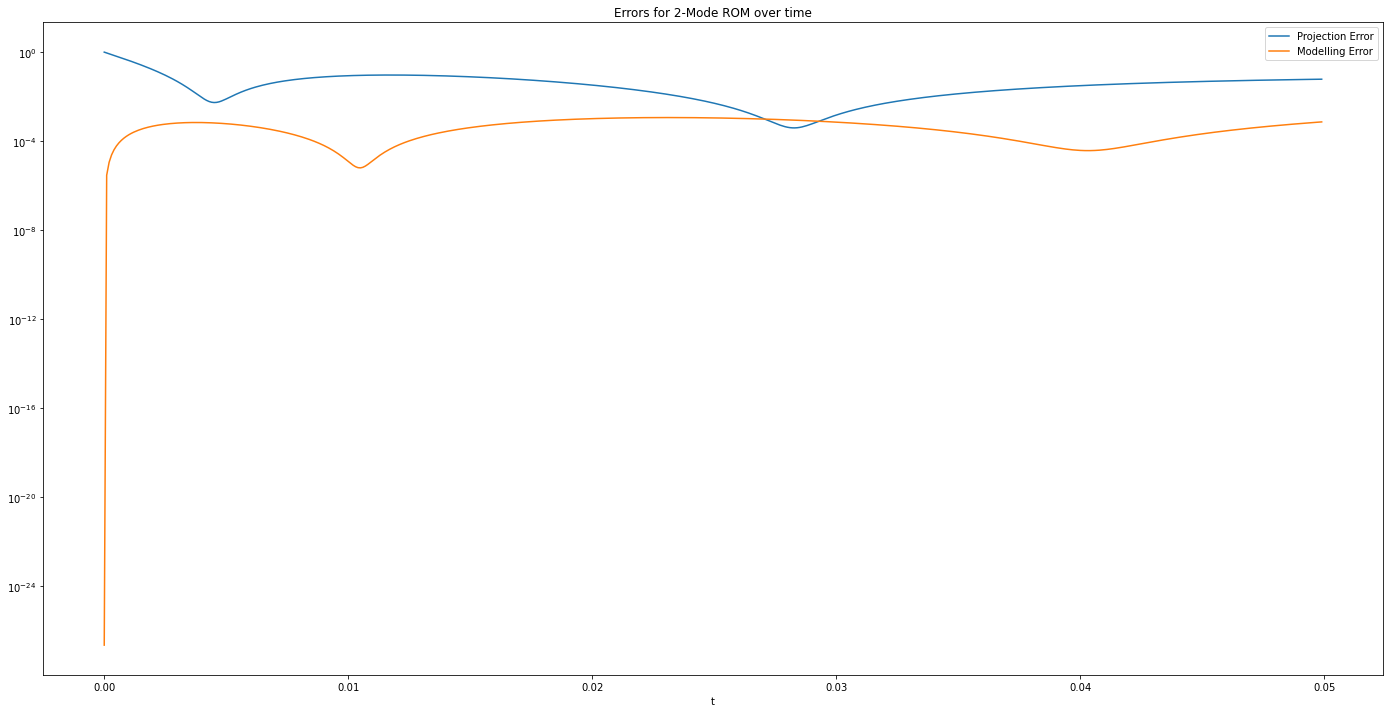

In [40]:
##### Plot of Projection and Model Error over time #####


%run -i Functions.py

Psi,Sigma,PhiT = np.linalg.svd(u)

Psi_r = Psi[:,:2]
Psi_r_inner = Psi_r@Psi_r.T
u_rom = Simulate_Heat_ROM_with_tolerance(u, u0, x, t, alpha, .99)

err_model = np.zeros(t.size)
err_proj = np.zeros(t.size)
for j in range(t.size):
    err_model[j] = np.linalg.norm(Psi_r_inner@u[:,j] - u_rom[:,j])**2
    err_proj[j] = np.linalg.norm(u[:,j] - Psi_r_inner@u[:,j])**2
    
Lambda = np.power(Sigma,2)

plt.plot(t, err_proj, label = 'Projection Error')
plt.plot(t, err_model, label = 'Modelling Error')
    

plt.yscale('log')
plt.xlabel('t')
#plt.ylabel('')
plt.title('Errors for 2-Mode ROM over time')
plt.legend()
plt.show()

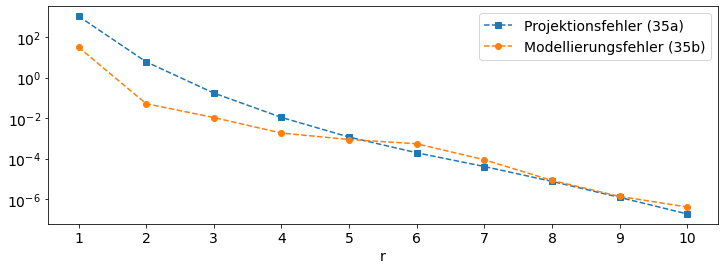

In [41]:
##### Testing of error convergence from EKY Theorem #####

%run -i Functions.py

# Reset FOM to N = 1000
N = 1000
dx = L/(N+1)
x = np.arange(-L/2,L/2,dx)
x = x[:N]
u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)
u = Simulate_Heat_FOM(u0, x, t, alpha)

# Error in 2 norm (sum of snapshots minus projected snapshots)
# Slower

"""
l = 10 # test cutoff
U,S,VT = np.linalg.svd(u)
errors_proj = np.zeros(l)
errors_model = np.zeros(l)
for r in range(1,l+1):
    Psi_r = U[:,:r]
    Psi_Inner = Psi_r@Psi_r.T
    u_rom = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, r)
    for k in range(t.size):
        errors_proj[r-1] += np.linalg.norm(u[:,k] - (Psi_Inner@u[:,k]))**2
        errors_model[r-1] += np.linalg.norm(Psi_Inner@u[:,k] - u_rom[:,k])**2
"""     

# Error in Forb norm (X - X_r)
# Faster and equivalent to above (without model error)
"""
l = 10 # test cutoff
U,S,VT = np.linalg.svd(u)
errors_proj = np.zeros(l)
for r in range(1,l+1):
    u_r = np.zeros_like(u)
    for i in range(r):
        u_r += S[i]*np.outer(U[:,i],VT.T[:,i])
    errors_proj[r] = np.linalg.norm(u - u_r, 'fro')**2/np.linalg.norm(u, 'fro')**2
"""

# Easiest way through Eigenvalues
l = 10
Psi,Sigma,PhiT = np.linalg.svd(u)
Lambda = np.power(Sigma,2)
errors_proj = np.zeros(l)
errors_model = np.zeros(l)


for j in range(l):
    errors_proj[j] = np.sum(Lambda[j+1:])

for r in range(1,l+1):
    Psi_r = Psi[:,:r]
    Psi_Inner = Psi_r@Psi_r.T
    u_rom = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, r)
    for k in range(t.size):
        errors_model[r-1] += np.linalg.norm(Psi_Inner@u[:,k] - u_rom[:,k])**2
        
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12,4))
plt.plot(range(1,l+1), errors_proj, label = 'Projektionsfehler', linestyle='dashed', marker='s')
plt.plot(range(1,l+1), errors_model, label = 'Modellierungsfehler', linestyle='dashed', marker='o')
    
plt.xticks(range(1,l+1), range(1,l+1))
plt.yscale('log')
plt.xlabel('r')
#plt.ylabel('')
plt.legend()
plt.savefig(f'{base_path}/errors.png', bbox_inches='tight', dpi=600)
plt.savefig(f'{base_path}/errors.svg', bbox_inches='tight', dpi=600)
plt.show()

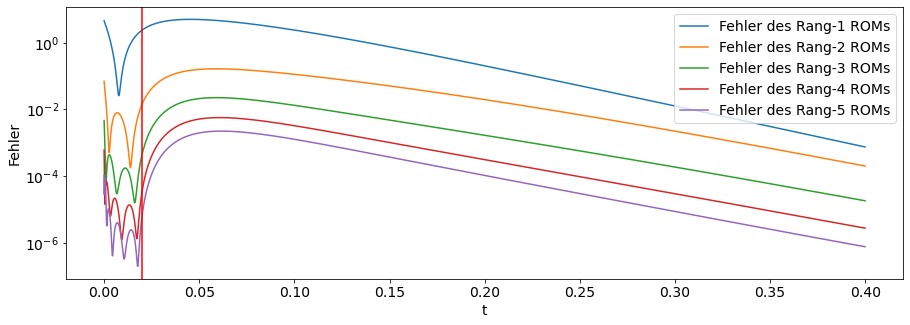

In [43]:
##### Testing of time extrapolation accuracy of ROMs #####

%run -i Functions.py

# Reset FOM to N = 1000
N = 1000
dx = L/(N+1)
x = np.arange(-L/2,L/2,dx)
x = x[:N]

# Beginning Simulation
t_range = 0.02
t = np.arange(0,t_range,dt)

# Initial condition
u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)

# FOM
u = Simulate_Heat_FOM(u0, x, t, alpha)

# Extrapolated Simulation
t_range = 0.4
t = np.arange(0,t_range,dt)

# ROMs
u_rom1 = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, 1)
u_rom2 = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, 2)
u_rom3 = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, 3)
u_rom4 = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, 4)
u_rom5 = Simulate_Heat_ROM_with_r(u, u0, x, t, alpha, 5)
# FOM for control
u_control = Simulate_Heat_FOM(u0, x, t, alpha)

errors_rom1 = np.zeros(t.size)
errors_rom2 = np.zeros(t.size)
errors_rom3 = np.zeros(t.size)
errors_rom4 = np.zeros(t.size)
errors_rom5 = np.zeros(t.size)
for tt in range(t.size):
    errors_rom1[tt] = np.linalg.norm(u_control[:,tt] - u_rom1[:,tt])**2
    errors_rom2[tt] = np.linalg.norm(u_control[:,tt] - u_rom2[:,tt])**2
    errors_rom3[tt] = np.linalg.norm(u_control[:,tt] - u_rom3[:,tt])**2
    errors_rom4[tt] = np.linalg.norm(u_control[:,tt] - u_rom4[:,tt])**2
    errors_rom5[tt] = np.linalg.norm(u_control[:,tt] - u_rom5[:,tt])**2
    

# Plotting
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,5))

plt.plot(t, errors_rom1, label = 'Fehler des Rang-1 ROMs')
plt.plot(t, errors_rom2, label = 'Fehler des Rang-2 ROMs')
plt.plot(t, errors_rom3, label = 'Fehler des Rang-3 ROMs')
plt.plot(t, errors_rom4, label = 'Fehler des Rang-4 ROMs')
plt.plot(t, errors_rom5, label = 'Fehler des Rang-5 ROMs')
plt.axvline(x=.02, color='r')

plt.yscale('log')
plt.xlabel('t')
plt.ylabel('Fehler')
plt.legend()
plt.savefig(f'{base_path}/extrapolation.png', bbox_inches='tight', dpi=600)
plt.savefig(f'{base_path}/extrapolation.svg', bbox_inches='tight', dpi=600)
plt.show()

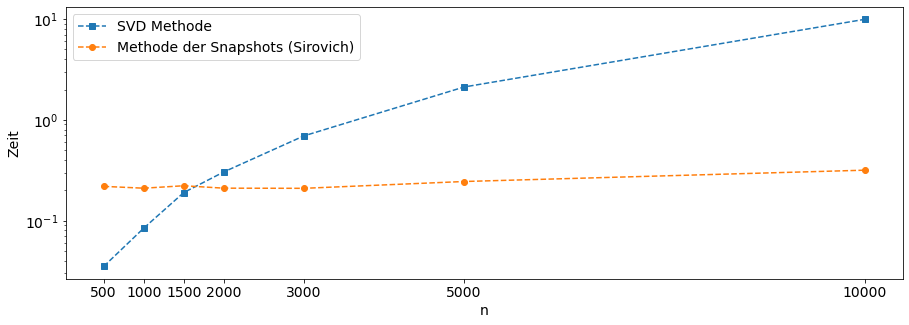

In [20]:
##### Time Testing SVD Method vs Method of Snapshots (Sirovich) for 2 Modes #####
##### ACHTUNG!! Dauert ziemlich lange, aufgrund von n=5000 bzw. n=10000 #####

def time_testing(N):
    %run -i Functions.py
    
    # Redefine x discretization
    dx = L/(N+1)
    x = np.arange(-L/2,L/2,dx)
    x = x[:N]

    # Initial condition
    u0 = np.sin(np.pi*x) - np.sin(2*np.pi*x) + np.sin(3*np.pi*x)

    # FOM
    u = Simulate_Heat_FOM(u0, x, t, alpha)
    
    d = np.linalg.matrix_rank(u)
    
    start_time = time.time()
    SVD_Method(u, d, .99)
    SVD_time = time.time() - start_time
    
    start_time = time.time()
    Sirovich_Method(u, d, .99)
    Sirovich_time = time.time() - start_time
    
    return SVD_time, Sirovich_time


#N_arr = [500, 1000, 1500, 3000, 5000, 10000, 15000]
N_arr = [500, 1000, 1500, 2000, 3000, 5000, 10000]

# Redefintion of timing like in the beginning
t_range = 0.05
dt = 0.0001
t = np.arange(0,t_range,dt)

timings = np.zeros((len(N_arr), 2))
for i in range(len(N_arr)):
    timings[i] = time_testing(N_arr[i])


plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,5))

plt.plot(N_arr, timings[:,0], label = "SVD Methode", linestyle='dashed', marker='s')
plt.plot(N_arr, timings[:,1], label = "Methode der Snapshots (Sirovich)", linestyle='dashed', marker='o') 
    
plt.xticks(N_arr, N_arr)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('Zeit in Sekunden')
plt.legend()
plt.savefig(f'{base_path}/sirovich.png', bbox_inches='tight', dpi=600)
plt.savefig(f'{base_path}/sirovich.svg', bbox_inches='tight', dpi=600)
plt.show()